In [1]:
import os
import pickle
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor, as_completed
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
sys.path.append(str(Path.cwd().parent))

In [2]:
# Directory containing pickle files
directory = Path("../results/regression_std/quantitative") # NOTE THE FILE PATH!!!

# Optionally filter for specific substrings
pkl_files = [f for f in directory.iterdir() if f.suffix == ".pkl"]

# Efficient loader
def load_file(file_path):
    try:
        with open(file_path, "rb") as f:
            data = pickle.load(f)
            if isinstance(data, dict):
                return file_path.name, data
    except (EOFError, pickle.UnpicklingError) as e:
        print(f"Warning: Failed to load {file_path.name}: {e}")
    except Exception as e:
        print(f"Unexpected error with {file_path.name}: {e}")
    return None

# Load files using multithreading (I/O bound)
all_data = {}
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(load_file, f) for f in pkl_files]
    for future in as_completed(futures):
        result = future.result()
        if result:
            filename, data = result
            all_data[filename] = data

files = list(all_data.keys())


In [3]:
records = []

for file, dictionary in all_data.items():
    records.append(dictionary)

# Create the DataFrame
df = pd.DataFrame(records)

print(df.shape)

(113379, 25)


In [4]:
# Prepare the dataframe
df = df[df['k'] != 1]
df['is_auto'] = pd.Series(df['k'] == 'auto', dtype=bool)
df['is_all'] = pd.Series(df['k'] == 'all', dtype=bool)
df.loc[df['is_all'], 'k'] = df['n_samples']
df.loc[df['k'].isna(), 'k'] = 'NA'
df.loc[df['prox_method'].isna(), 'prox_method'] = 'NA'

In [5]:
df['Method'] = df['method']
df.loc[df['Method'] == 'qrf', 'Method'] = 'QRF'

df.loc[df['Method'] == 'zrf', 'Method'] = 'OOB Int.' # Perhaps change this name

df.loc[(df['Method'] == 'proximity_based') & (df['prox_method'] == 'rfgap'), 'Method'] = 'RF-FIRE'
df.loc[(df['Method'] == 'proximity_based') & (df['prox_method'] == 'original'), 'Method'] = 'RF-FIRE (Original)'
df.loc[(df['Method'] == 'proximity_based') & (df['prox_method'] == 'oob'), 'Method'] = 'RF-FIRE (OOB)'

/tmp/ipykernel_1958531/900224728.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  [cm.get_cmap('Dark2')(i / (len(unique_levels) - 1)) for i in range(len(unique_levels))]


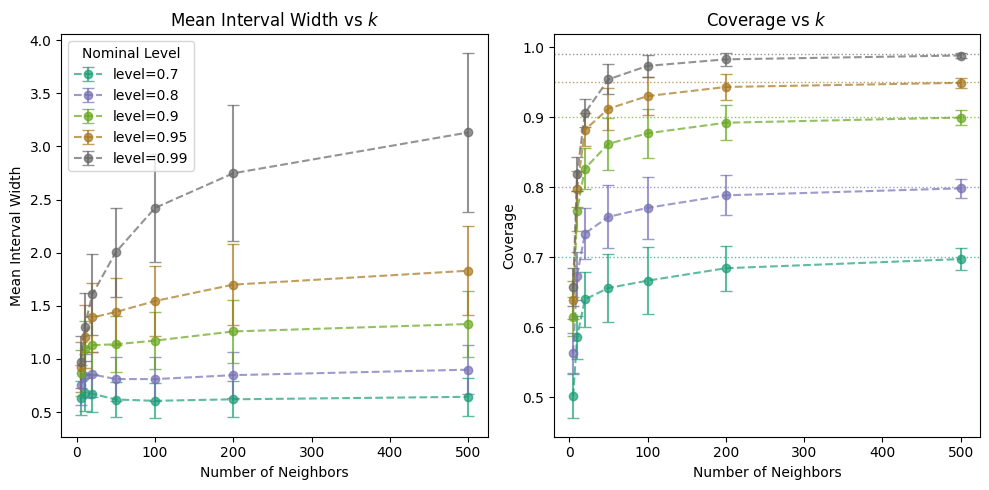

In [6]:


# Compute mean and std for width_mean and coverage for each group
pivot_df = (
    df[
        (df['k'].isin([5, 10, 20, 50, 100, 200, 500])) &
        (df['method'] == 'proximity_based') &
        (df['prox_method'].isin(['rfgap', 'original']))
    ]
    .groupby(['prox_method', 'level', 'k'])
    .agg(
        width_mean_mean=('width_mean', 'mean'),
        width_mean_std=('width_mean', 'std'),
        coverage_mean=('coverage', 'mean'),
        coverage_std=('coverage', 'std')
    )
    .reset_index()
)


# Use a perceptually uniform colormap for levels
unique_levels = sorted(pivot_df[pivot_df['prox_method'] == 'rfgap']['level'].unique())
level_palette = dict(zip(
    unique_levels,
    [cm.get_cmap('Dark2')(i / (len(unique_levels) - 1)) for i in range(len(unique_levels))]
))



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

# Only plot 'rfgap' prox_method for mean interval width
for level, subgrp in pivot_df[pivot_df['prox_method'] == 'rfgap'].groupby('level'):
    n = len(subgrp['k'])
    ax1.errorbar(
        subgrp['k'],
        subgrp['width_mean_mean'],
        yerr=subgrp['width_mean_std'] / np.sqrt(n),
        marker='o',
        color=level_palette[level],
        alpha = 0.7,
        label=f"level={level}",
        linestyle='--',
        capsize=4
    )

ax1.set_xlabel('Number of Neighbors')
ax1.set_ylabel('Mean Interval Width')
ax1.set_title(r'Mean Interval Width vs $k$')
ax1.legend(title='Nominal Level')

# Only plot 'rfgap' prox_method for coverage
for level, subgrp in pivot_df[pivot_df['prox_method'] == 'rfgap'].groupby('level'):
    ax2.errorbar(
        subgrp['k'],
        subgrp['coverage_mean'],
        yerr=subgrp['coverage_std'],
        marker='o',
        color=level_palette[level],
        alpha=0.7,
        label=f"level={level}",
        linestyle='--',
        capsize=4
    )
    ax2.axhline(level, color=level_palette[level], linestyle=':', linewidth=1, alpha=0.7)

ax2.set_xlabel('Number of Neighbors')
ax2.set_ylabel('Coverage')
ax2.set_title(r'Coverage vs $k$')

plt.tight_layout()
plt.show()


/tmp/ipykernel_1958531/3137093588.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  [cm.get_cmap('Dark2')(i / (len(unique_levels) - 1)) for i in range(len(unique_levels))]


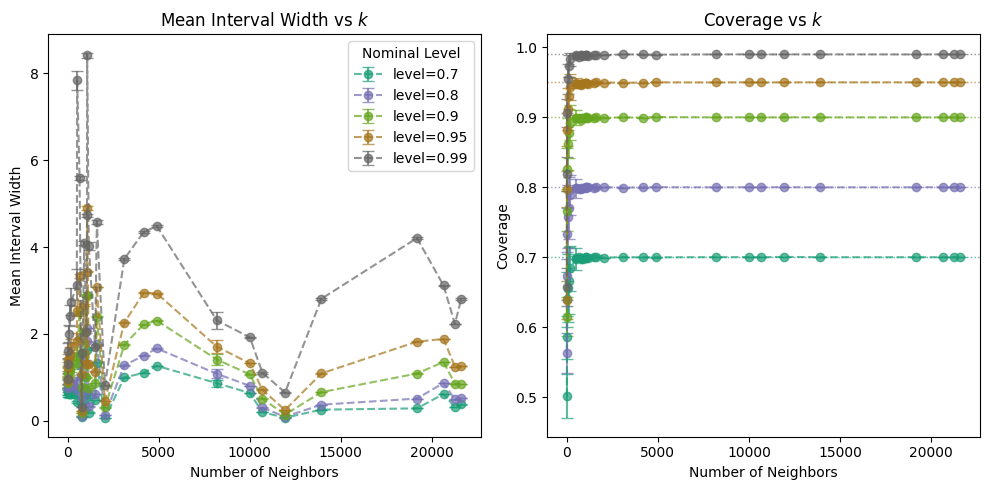

In [7]:


# Compute mean and std for width_mean and coverage for each group
pivot_df = (
    df[
        (~df['k'].isin(['auto', 'NA'])) &
        (df['method'] == 'proximity_based') &
        (df['prox_method'].isin(['rfgap', 'original']))
    ]
    .groupby(['prox_method', 'level', 'k'])
    .agg(
        width_mean_mean=('width_mean', 'mean'),
        width_mean_std=('width_mean', 'std'),
        coverage_mean=('coverage', 'mean'),
        coverage_std=('coverage', 'std')
    )
    .reset_index()
)


# Use a perceptually uniform colormap for levels
unique_levels = sorted(pivot_df[pivot_df['prox_method'] == 'rfgap']['level'].unique())
level_palette = dict(zip(
    unique_levels,
    [cm.get_cmap('Dark2')(i / (len(unique_levels) - 1)) for i in range(len(unique_levels))]
))



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

# Only plot 'rfgap' prox_method for mean interval width
for level, subgrp in pivot_df[pivot_df['prox_method'] == 'rfgap'].groupby('level'):
    n = len(subgrp['k'])
    ax1.errorbar(
        subgrp['k'],
        subgrp['width_mean_mean'],
        yerr=subgrp['width_mean_std'] / np.sqrt(n),
        marker='o',
        color=level_palette[level],
        alpha = 0.7,
        label=f"level={level}",
        linestyle='--',
        capsize=4
    )

ax1.set_xlabel('Number of Neighbors')
ax1.set_ylabel('Mean Interval Width')
ax1.set_title(r'Mean Interval Width vs $k$')
ax1.legend(title='Nominal Level')

# Only plot 'rfgap' prox_method for coverage
for level, subgrp in pivot_df[pivot_df['prox_method'] == 'rfgap'].groupby('level'):
    ax2.errorbar(
        subgrp['k'],
        subgrp['coverage_mean'],
        yerr=subgrp['coverage_std'],
        marker='o',
        color=level_palette[level],
        alpha=0.7,
        label=f"level={level}",
        linestyle='--',
        capsize=4
    )
    ax2.axhline(level, color=level_palette[level], linestyle=':', linewidth=1, alpha=0.7)

ax2.set_xlabel('Number of Neighbors')
ax2.set_ylabel('Coverage')
ax2.set_title(r'Coverage vs $k$')

plt.tight_layout()
plt.show()


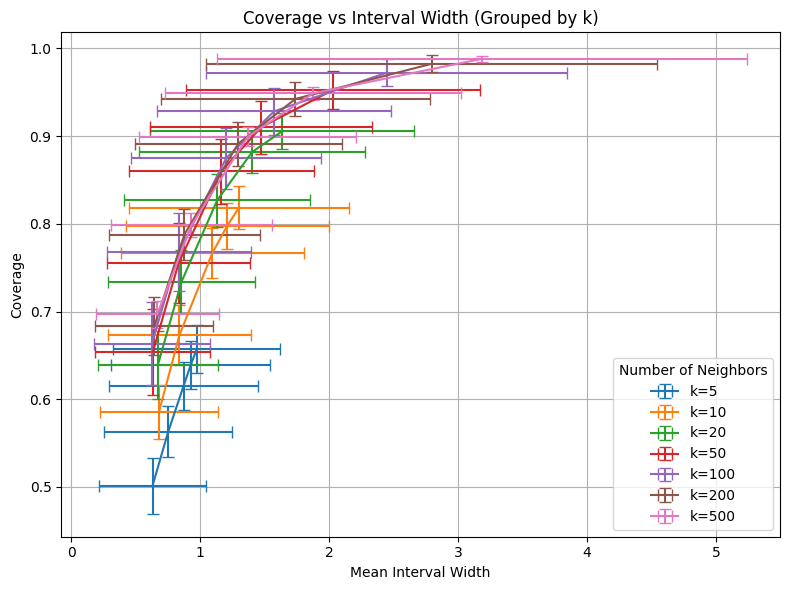

In [ ]:
import matplotlib.pyplot as plt

# Filter just the 'rfgap' method
rfgap_df = pivot_df[pivot_df['prox_method'] == 'rfgap']

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Group by k (number of neighbors)
for k, subgrp in rfgap_df.groupby('k'):
    ax.errorbar(
        subgrp['width_mean_mean'],
        subgrp['coverage_mean'],
        xerr=subgrp['width_mean_std'],
        yerr=subgrp['coverage_std'],
        # marker=prox_styles.get('rfgap', 'o'),
        linestyle='-',
        label=f'k={k}',
        capsize=4
    )

ax.set_xlabel('Mean Interval Width')
ax.set_ylabel('Coverage')
ax.set_title('Coverage vs Interval Width (Grouped by k)')
ax.legend(title='Number of Neighbors')
ax.grid(True)
plt.tight_layout()
plt.show()


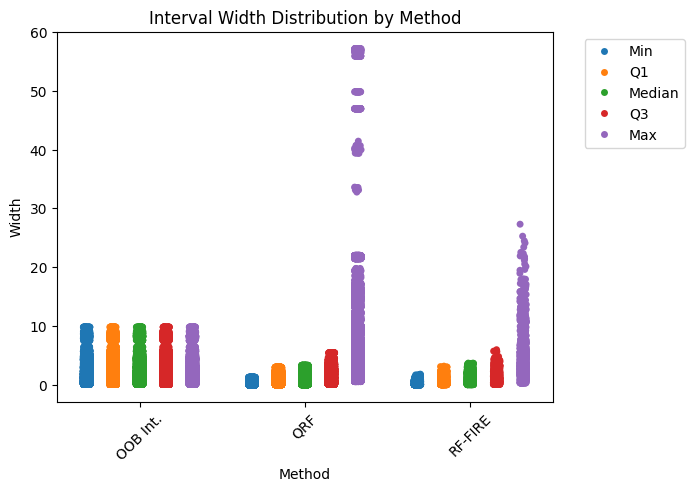

In [ ]:
# Keep something like this as well.
# May need to do some grouping by k!!!

# WAS WORKING WITHOUT K
width_quantiles = df[['Method', 'k', 'width_min', 'width_q1', 'width_median', 'width_q3', 'width_max']]
width_quantiles = width_quantiles.loc[width_quantiles['k'].isin(['NA', 'auto'])]

width_quantiles = width_quantiles[['Method', 'width_min', 'width_q1', 'width_median', 'width_q3', 'width_max']]



# width_quantiles = df[['Method', 'width_min_test', 'width_q1_test', 'width_median_test', 'width_q3_test', 'width_max_test']]
width_quantiles = width_quantiles[width_quantiles['Method'].isin(['QRF', 'OOB Int.', 'RF-FIRE'])]
long_df = width_quantiles.melt(id_vars='Method', var_name='quantile', value_name='Width')

# Rename quantile values for prettier legend
quantile_map = {
    'width_min': 'Min',
    'width_q1': 'Q1',
    'width_median': 'Median',
    'width_q3': 'Q3',
    'width_max': 'Max'
}
long_df['quantile'] = long_df['quantile'].map(quantile_map)

sns.stripplot(data=long_df, x='Method', y='Width', hue='quantile', dodge = True)
# plt.yscale('log')
plt.title('Interval Width Distribution by Method')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
def balanced_interval_score(width, coverage, target_coverage=0.95, penalty_weight=1.0):
    """
    Compute the Balanced Interval Score (BIS).
    
    Parameters:
    - width: float or array-like, the width(s) of the interval(s)
    - coverage: float or array-like, the empirical coverage rate(s) (e.g., proportion of times true value in interval)
    - target_coverage: float, desired coverage level (e.g., 0.95)
    - penalty_weight: float, how heavily to penalize deviations from target coverage
    
    Returns:
    - BIS value(s): float or array-like
    """
    import numpy as np
    
    width = np.asarray(width)
    coverage = np.asarray(coverage)
    penalty = 1 + penalty_weight * np.abs(coverage - target_coverage)
    bis = 1.0 / (width * penalty)
    
    return bis


In [ ]:
widths = df['width_median']
coverages = df['coverage']
levels = df['level']
df['bis'] = balanced_interval_score(df['width_mean'], df['coverage'], df['level'],
                                    penalty_weight=1)

<Axes: xlabel='Method', ylabel='bis'>

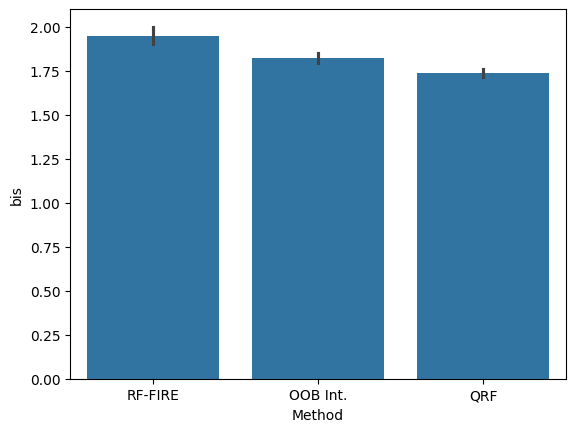

In [ ]:
# Keep something like this.
sns.barplot(data=df[df['Method'].isin(['RF-FIRE', 'QRF', 'OOB Int.'])], x='Method', y='bis')

In [ ]:
# Filter methods of interest
methods = ['RF-FIRE', 'QRF', 'OOB Int.']
filtered_df = df[df['Method'].isin(methods)]

# Compute mean and standard error
summary = (
    filtered_df.groupby('Method')['bis']
    .agg(['mean', 'std', 'count'])
    .assign(sem=lambda d: d['std'] / np.sqrt(d['count']))
    .reset_index()
)

# Sort descending by mean
summary = summary.sort_values(by='mean', ascending=False).reset_index(drop=True)

# Identify the top method for bolding
top_method = summary.loc[0, 'Method']

# Generate LaTeX rows with bolding
latex_rows = []
for _, row in summary.iterrows():
    method = row['Method']
    mean = f"{row['mean']:.3f}"
    sem = f"{row['sem']:.3f}"
    line = f"{method} & {mean} $\\pm$ {sem} \\\\"
    if method == top_method:
        line = r"\textbf{" + line + "}"
    latex_rows.append(line)

# Construct LaTeX table
latex_table = r"""\begin{tabular}{l c}
\toprule
Method & bis ($\pm$ SEM) \\
\midrule
""" + "\n".join(latex_rows) + r"""
\bottomrule
\end{tabular}
"""

print(latex_table)


\begin{tabular}{l c}
\toprule
Method & bis ($\pm$ SEM) \\
\midrule
\textbf{RF-FIRE & 1.949 $\pm$ 0.026 \\}
OOB Int. & 1.822 $\pm$ 0.015 \\
QRF & 1.736 $\pm$ 0.011 \\
\bottomrule
\end{tabular}

